In [1]:
###======= Imports =======###
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries 
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from CustomRWKV import RwkvConfig, RwkvModel, RwkvPreTrainedModel
from rwkv.model import RWKV
import math


c:\Users\Latzres\Anaconda3\envs\deep_proj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###======= Config Dictionary =======###
config = {
    "alpha_vantage": {
        "key": "JG7TR7PA6FKE0DCG",
        "symbol": "MSFT",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.7,
        "val_split_size": 0.2,
        "test_split_size": 0.1
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#561F78",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Number data points 5945 from 1999-11-01 to 2023-06-16


C:\Users\Latzres\AppData\Local\Temp\ipykernel_36600\4165524928.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


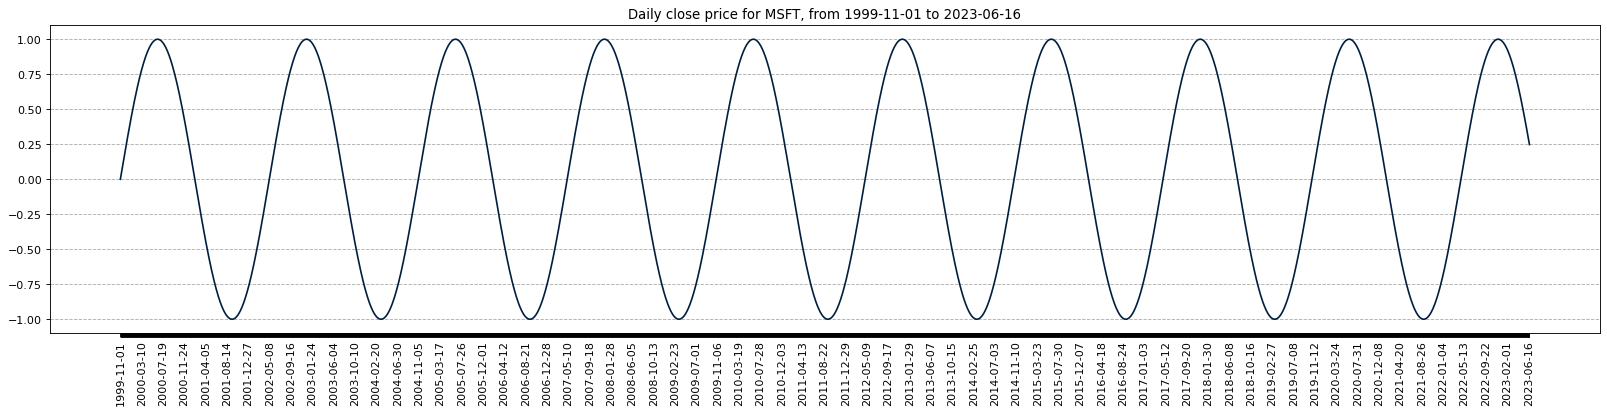

In [3]:
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"]) #you can use the demo API key for this project, but please make sure to eventually get your own API key at https://www.alphavantage.co/support/#api-key. 
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)
data_close_price = np.sin([i / 100 for i in range(num_data_points)])
# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

In [4]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

[[-0.04682523 -0.0326952  -0.01856659 ...  0.19223382  0.2061482
   0.22003729]
 [-0.0326952  -0.01856659 -0.00444081 ...  0.2061482   0.22003729
   0.23389969]
 [-0.01856659 -0.00444081  0.00968074 ...  0.22003729  0.23389969
   0.24773401]
 ...
 [ 0.59344289  0.58081466  0.56812367 ...  0.37110401  0.35758528
   0.3440261 ]
 [ 0.58081466  0.56812367  0.55537118 ...  0.35758528  0.3440261
   0.33042784]
 [ 0.56812367  0.55537118  0.54255848 ...  0.3440261   0.33042784
   0.31679185]]
[0.55537118 0.54255848 0.52968684 0.51675755 0.50377189 0.49073118
 0.47763672 0.46448981 0.45129177 0.43804391 0.42474757 0.41140408
 0.39801476 0.38458096 0.37110401 0.35758528 0.3440261  0.33042784
 0.31679185 0.30311951]


C:\Users\Latzres\AppData\Local\Temp\ipykernel_36600\1341635895.py:52: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


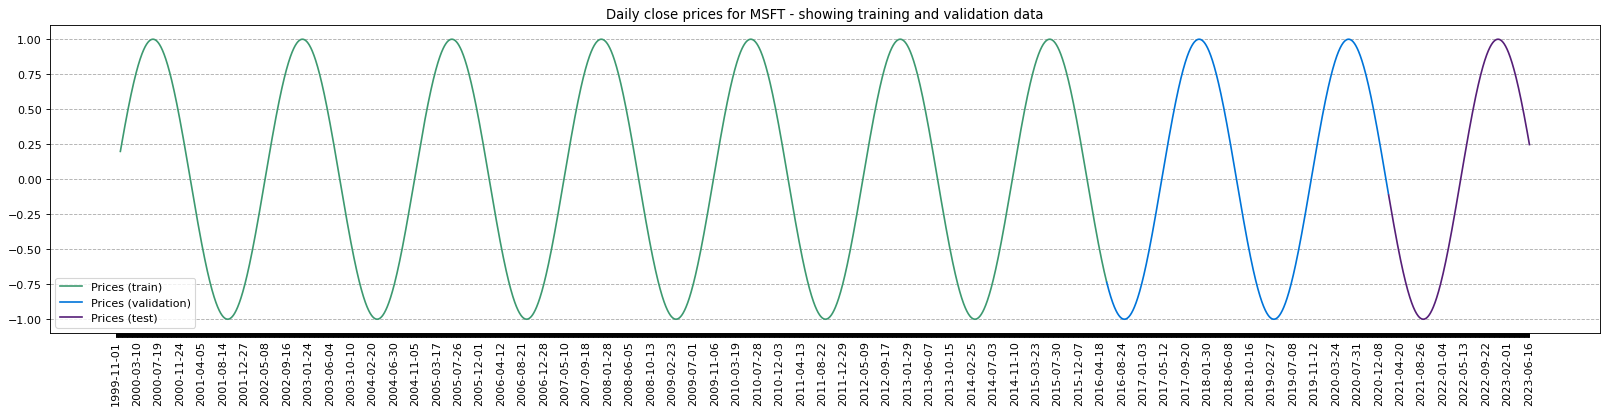

In [5]:
def prepare_data_x(x: np.ndarray, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
print(data_x)
print(data_x_unseen)
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

# Split dataset
split_index_train = int(data_y.shape[0] * config["data"]["train_split_size"])
split_index_val = int(data_y.shape[0] * config["data"]["val_split_size"]) + split_index_train

data_x_train = data_x[:split_index_train]
data_x_val = data_x[split_index_train:split_index_val]
data_x_test = data_x[split_index_val:]
data_y_train = data_y[:split_index_train]
data_y_val = data_y[split_index_train:split_index_val]
data_y_test = data_y[split_index_val:]

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index_train+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index_train+config["data"]["window_size"]:split_index_val+config["data"]["window_size"]] = scaler.inverse_transform(data_y_val)
to_plot_data_y_test[split_index_val+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_test)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color=config["plots"]["color_test"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
dataset_test = TimeSeriesDataset(data_x_test, data_y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (4147, 20, 1) (4147,)
Validation data shape (1185, 20, 1) (1185,)
Test data shape (593, 20, 1) (593,)


In [7]:
# Define Transformer Model
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5, norm_first=False):
        super(TransformerModel, self).__init__()
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout, norm_first=norm_first)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [8]:
# instantiate Transformer model
transformer_model = TransformerModel(ntoken=int(20e3), ninp=220, nhead=2, nhid=220, nlayers=4, dropout=0.2, norm_first=True)

In [9]:
# Define RWKV model
rwkv_config = RwkvConfig(vocab_size=0, context_length=20, hidden_size=20, use_cache=False, num_hidden_layers=2)
rwkv_model = RwkvModel(rwkv_config)

In [10]:
epochs = 20
criterion = nn.MSELoss()
optimizer = torch.optim.RAdam(transformer_model.parameters(), lr=5e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model = rwkv_model
model.to(device)

RwkvModel(
  (blocks): ModuleList(
    (0): RwkvBlock(
      (pre_ln): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (ln1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (attention): RwkvSelfAttention(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=20, out_features=20, bias=False)
        (value): Linear(in_features=20, out_features=20, bias=False)
        (receptance): Linear(in_features=20, out_features=20, bias=False)
        (output): Linear(in_features=20, out_features=20, bias=False)
      )
      (feed_forward): RwkvFeedForward(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=20, out_features=80, bias=False)
        (receptance): Linear(in_features=20, out_features=20, bias=False)
        (value): Linear(in_features=80, out_features=20, bias=False)
      )
    )
    (1): RwkvBlock(
      (ln1): LayerNorm((20,), eps=1e-05, 

In [12]:
def evaluate(data_loader):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0 
    losses = 0.0
    for _, (x, y) in enumerate(data_iterator):
        x = x.view(x.size(0), x.size(1)).to(device)
        y = y.to(device)
        out = model(x)
        out = out.last_hidden_state.view(x.size(0))
        loss = criterion(out, y.contiguous())
        losses += loss
        
    print(f"eval loss: {losses / nb_batches}")
    

def train(train_loader, valid_loader):
    
    for epoch in range(epochs):
        train_iterator, valid_iterator = iter(train_loader), iter(valid_loader)
        nb_batches_train = len(train_loader)
        train_acc = 0
        model.train()
        losses = 0.0

        for idx, (x, y) in enumerate(train_loader):
            x = x.view(x.size(0), x.size(1)).to(device)
            y = y.to(device)
            # print(x.shape)
            out = model(x)
            out = out.last_hidden_state.view(x.size(0))
            # print(out.shape)
            print(y.shape)
            loss = criterion(out, y.contiguous())
            
            optimizer.zero_grad()

            loss.backward()
            losses += loss.item()

            optimizer.step()
        
        print(f"epoch {epoch}: train loss: {losses / nb_batches_train}")
        # print(f"training accuracy: {train_acc / nb_batches_train}")
        print('evaluating on validation:')
        evaluate(valid_loader)

In [13]:
train(train_dataloader, val_dataloader)

torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])


KeyboardInterrupt: 

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()
# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.view(x.size(0), x.size(1)).to(device)
    out = model(x)
    out = out.last_hidden_state.view(x.size(0))
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.view(x.size(0), x.size(1)).to(device)
    out = model(x)
    out = out.last_hidden_state.view(x.size(0))
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index_train+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index_train+config["data"]["window_size"]:split_index_val+config["data"]["window_size"]] = scaler.inverse_transform(predicted_val)
to_plot_data_y_train_pred[config["data"]["window_size"]:split_index_train+config["data"]["window_size"]] = predicted_train
to_plot_data_y_val_pred[split_index_train+config["data"]["window_size"]:split_index_val+config["data"]["window_size"]] = predicted_val

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()